# **HAVOK critic dataset generator**

> Laboratory of Computational Physics // University of Padua, AY 2021/22<br> 
> **Group 2202** / Barone Nagaro Ninni Valentini

## generate dynamic system sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
my_grey = (0.3,0.3,0.3)
do_savefig = False
path_savefig = '../img/lorenz_demolol/'

import time as time
import random

from sys_lorenz import LorenzSystem

dsys = LorenzSystem()  # defaults sigma=10, beta=8/3, rho=28, dt = 0.01
dt = 0.001

nsamples = 1000000
ndump = 0 # samples to dump for system initialization

In [2]:
U_FILE = 'u.csv'

In [3]:
# preallocate
xs = np.empty( (nsamples, 3) )

# set initial values
x0 = np.array( [-8, 8, 27] )

# dump initial propagation
for i in range(ndump):
    x_dot = dsys.dynamics( x0 )
    x0 += x_dot * dt

xs[0] = x0

# compute dataset
tic = time.time()
for i in range(nsamples-1):
    x_dot = dsys.dynamics( xs[i] )
    xs[i + 1] = xs[i] + (x_dot * dt)

toc = time.time()
print ('Computation elapsed time:',toc-tic,'seconds.')

Computation elapsed time: 2.8954672813415527 seconds.


### brief data inspection

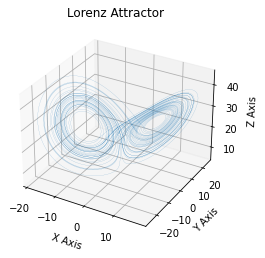

In [4]:
def Plot3D(xs, ys, zs, title, start, pt_number, lw):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs[start:start+pt_number], ys[start:start+pt_number], zs[start:start+pt_number], lw=lw)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title(title)
    plt.show()

Plot3D(xs[:,0], xs[:,1], xs[:,2], "Lorenz Attractor", start=0, pt_number=50000, lw=0.1)

In [5]:
#xx, yy, zz = np.loadtxt('../../../data/sb2017/Lorenz_extended.csv', unpack=True)

In [6]:
#!head '../../../data/sb2017/Lorenz_extended.csv'

In [7]:
# select a coordinate for HAVOK analysis, which from now on
# will be called x, regardless of its origin
x = xs[:, 0]
tt = np.arange( len(x) )*dt

## HAVOK thresholding

In [8]:
## load convolution matrix
r = 15
Umat = np.loadtxt(U_FILE)
q = Umat.shape[0]
Umat = Umat[:,[0,r-1]]

print('U matrix loaded, using convolution size =', q)

U matrix loaded, using convolution size = 100


In [9]:
thres = 0.002
coeff = 1/9.740682624852331e-09
r = 15

In [10]:
# init moving window
data_mat = np.empty(q)
data_mat = x[0:q]

vr_status = np.zeros(len(x), dtype=bool)
v1 = np.zeros(len(x))
vr = np.zeros(len(x))
vt = tt[0:len(x)]
hist_active = 0        # forcing active history counter
sign = +1
candidate_index = 0
candidates = []

# propagate moving window
for i in range(q, len(x)):
    data_mat = np.roll(data_mat, -1);
    data_mat[-1] = x[i];
    
    # compute v1 & forcing term
    v = np.matmul(Umat.T, data_mat)*coeff
    this_v1 = v[0];  this_vr = v[1]
    
    # perform logic on threshold model
    this_active = abs(this_vr) > thres
    
    if hist_active == 0: # no history so far
        cc = True if(this_active) else False
        
        if this_active:  # get the first activation
            hist_active = 500
            candidate_sign = np.sign(this_v1)
            #print(candidate_sign)
            candidate_index = i
    else:
        cc = True;   hist_active -= 1;
        if hist_active == 0: # conclusion of active history
            #print('>>', this_v1)
            if this_v1*candidate_sign < 0:  # check for sign inversion
                candidates.append(candidate_index)
                
    # buffering      
    v1[i], vr[i], vr_status[i] = this_v1, this_vr, cc
                  
print(len(candidates), 'events detected')

463 events detected


In [11]:
# plotting
def havok_mw_plot(v1, vr, vr_status, vt, title='Sliding window'):
    fig, ax = plt.subplots(2, 1, figsize=(9,6))
    
    yabove = np.ma.masked_where(np.invert(vr_status), v1)
    ybelow = np.ma.masked_where(vr_status, v1)
    
    ax[0].plot(vt, ybelow, lw=1.5, c='silver', label='Havok')
    ax[0].plot(vt, yabove, lw=1.5, c='red', label='Havok active')
    
    ax[0].set(ylabel='$v_1$')
    ax[0].tick_params(axis='y', rotation=45)
    #ax[0].set_xlim([6,7])
    
    yabove = np.ma.masked_where(np.invert(vr_status), vr)
    ybelow = np.ma.masked_where(vr_status, vr)
    
    ax[1].plot(vt, ybelow, lw=1.5, c='silver', label='Havok')
    ax[1].plot(vt, yabove, lw=1.5, c='red', label='Havok active')
    ax[1].tick_params(axis='y', rotation=45)
    ax[1].legend(loc='upper left')
    #ax[1].set_xlim([6,7])
    
    plt.xlabel('time [s]')
    plt.ylabel(r'   $v_r$         ', rotation=0)
    plt.suptitle(title, fontweight='bold')
    plt.show()

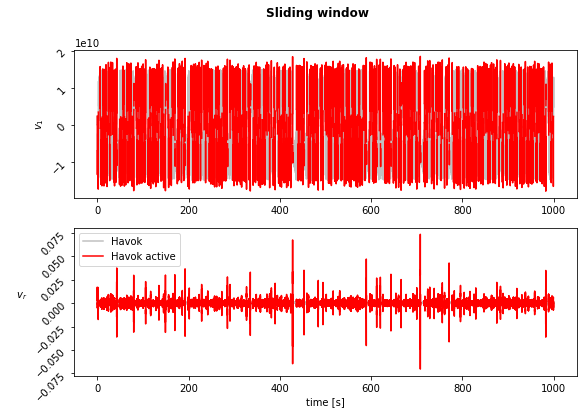

In [12]:
havok_mw_plot(v1, vr, vr_status, vt)

### plot sample candidates

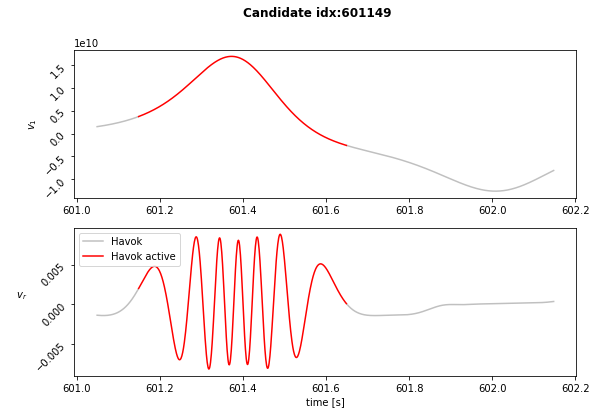

In [22]:
def plot_candidate(idx):
    offset_sx, offset_dx = 100, 1000
    sxdx = np.arange(idx-offset_sx,idx+offset_dx)
    havok_mw_plot(v1[sxdx], vr[sxdx], vr_status[sxdx], vt[sxdx], title=f'Candidate idx:{idx}')

plot_candidate(random.choice(candidates))

### save candidates to file as (x, y, z)

In [23]:
np.savetxt('havok_critic_Lorenz.csv', xs[candidates])
print(len(candidates), 'events saved')

463 events saved


***

End of demo.

Code by Francesco Barone, 15 may 2022.

University of Padua, Laboratory of Computational Physics, module B.